In [25]:
#import all necessary modules
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from keras.utils.vis_utils import plot_model 
from keras.preprocessing.image import ImageDataGenerator,image 
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.models import Sequential,Model,load_model
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os

In [26]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [28]:
!nvidia-smi

Sun Mar 19 00:29:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8     9W / 132W |   5467MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
#define height and width of the image
height=300
width=300

#create a ResNet50 model instance without the top layer as we will add our own top layer
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(height,width,3))

In [30]:
#define directory containing training and validation data
train_dir="Dataset/Training"
validation_dir="Dataset/Validation"

#number of batches the data has to be divided into
batch_size=8

#create datagen and generator to load the data from training directory
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(height,width),batch_size=batch_size)

#create datagen and generator to load the data from validation directory
validation_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
validation_generator=validation_datagen.flow_from_directory(validation_dir,target_size=(height,width),batch_size=batch_size)

Found 35 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [31]:
#our own model which will be added onto the ResNet50 model
def build_finetune_model(base_model,dropout,fc_layers,num_classes):
    for layer in base_model.layers:
        layer.trainable=False

    x=base_model.output
    x=Flatten()(x)
    for fc in fc_layers:
        x=Dense(fc,activation='relu')(x)
        x=Dropout(dropout)(x)
    
    predictions=Dense(num_classes,activation='softmax')(x)

    finetune_model=Model(inputs=base_model.input,outputs=predictions) 
    
    return finetune_model

class_list=['Real','Fake'] #the labels of our data
FC_Layers=[1024,1024]
dropout=0.5

finetune_model=build_finetune_model(base_model,dropout=dropout,fc_layers=FC_Layers,num_classes=len(class_list))

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [ ]:
finetune_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

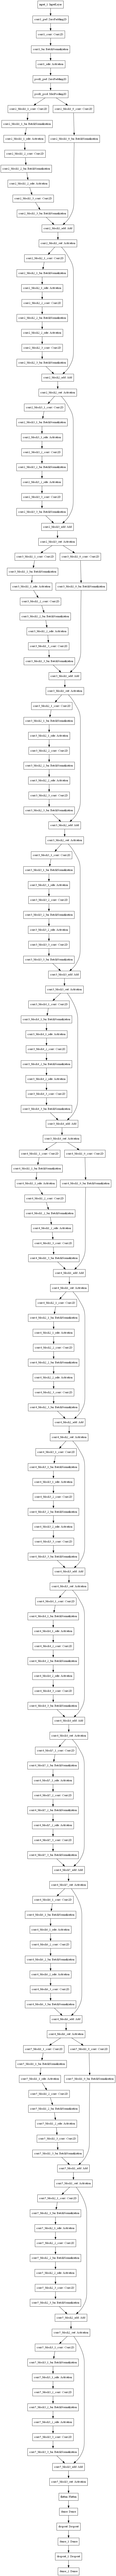

In [ ]:
plot_model(finetune_model,'ResNet_CNN_arch.png')

In [ ]:
#define number of epochs(the number of times the model will be trained) and number of training images
num_epochs=100
num_train_images=35


In [35]:
from keras.callbacks import TensorBoard
filepath=os.path.join(os.getcwd(),"logs")
tensorboard_call = TensorBoard(filepath,write_graph=True,write_images=True)

In [36]:
#compile the model before using
finetune_model.compile(loss="categorical_crossentropy",optimizer=optimizers.SGD(learning_rate=0.000001,momentum=0.9),metrics=['accuracy'])


In [37]:
with tf.device('/GPU:0'):
    history = finetune_model.fit(train_generator,
                                        steps_per_epoch=num_train_images//batch_size,
                                        epochs=num_epochs,
                                        validation_data=validation_generator,
                                        validation_steps=1,callbacks=[tensorboard_call])

Epoch 1/100
4/4 [==============================] - 14s 3s/step - loss: 0.8446 - accuracy: 0.7500 - val_loss: 0.4418 - val_accuracy: 0.5714
Epoch 2/100
4/4 [==============================] - 1s 271ms/step - loss: 0.9333 - accuracy: 0.7500 - val_loss: 0.4890 - val_accuracy: 0.8571
Epoch 3/100
4/4 [==============================] - 2s 332ms/step - loss: 0.7329 - accuracy: 0.6667 - val_loss: 0.6015 - val_accuracy: 0.7143
Epoch 4/100
4/4 [==============================] - 1s 319ms/step - loss: 0.7623 - accuracy: 0.7407 - val_loss: 0.2510 - val_accuracy: 0.8571
Epoch 5/100
4/4 [==============================] - 1s 283ms/step - loss: 1.1616 - accuracy: 0.5312 - val_loss: 0.5505 - val_accuracy: 0.7143
Epoch 6/100
4/4 [==============================] - 1s 282ms/step - loss: 1.0635 - accuracy: 0.6562 - val_loss: 0.3146 - val_accuracy: 0.8571
Epoch 7/100
4/4 [==============================] - 1s 267ms/step - loss: 0.8295 - accuracy: 0.6667 - val_loss: 0.6504 - val_accuracy: 0.5714
Epoch 8/100
4/4

In [38]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss

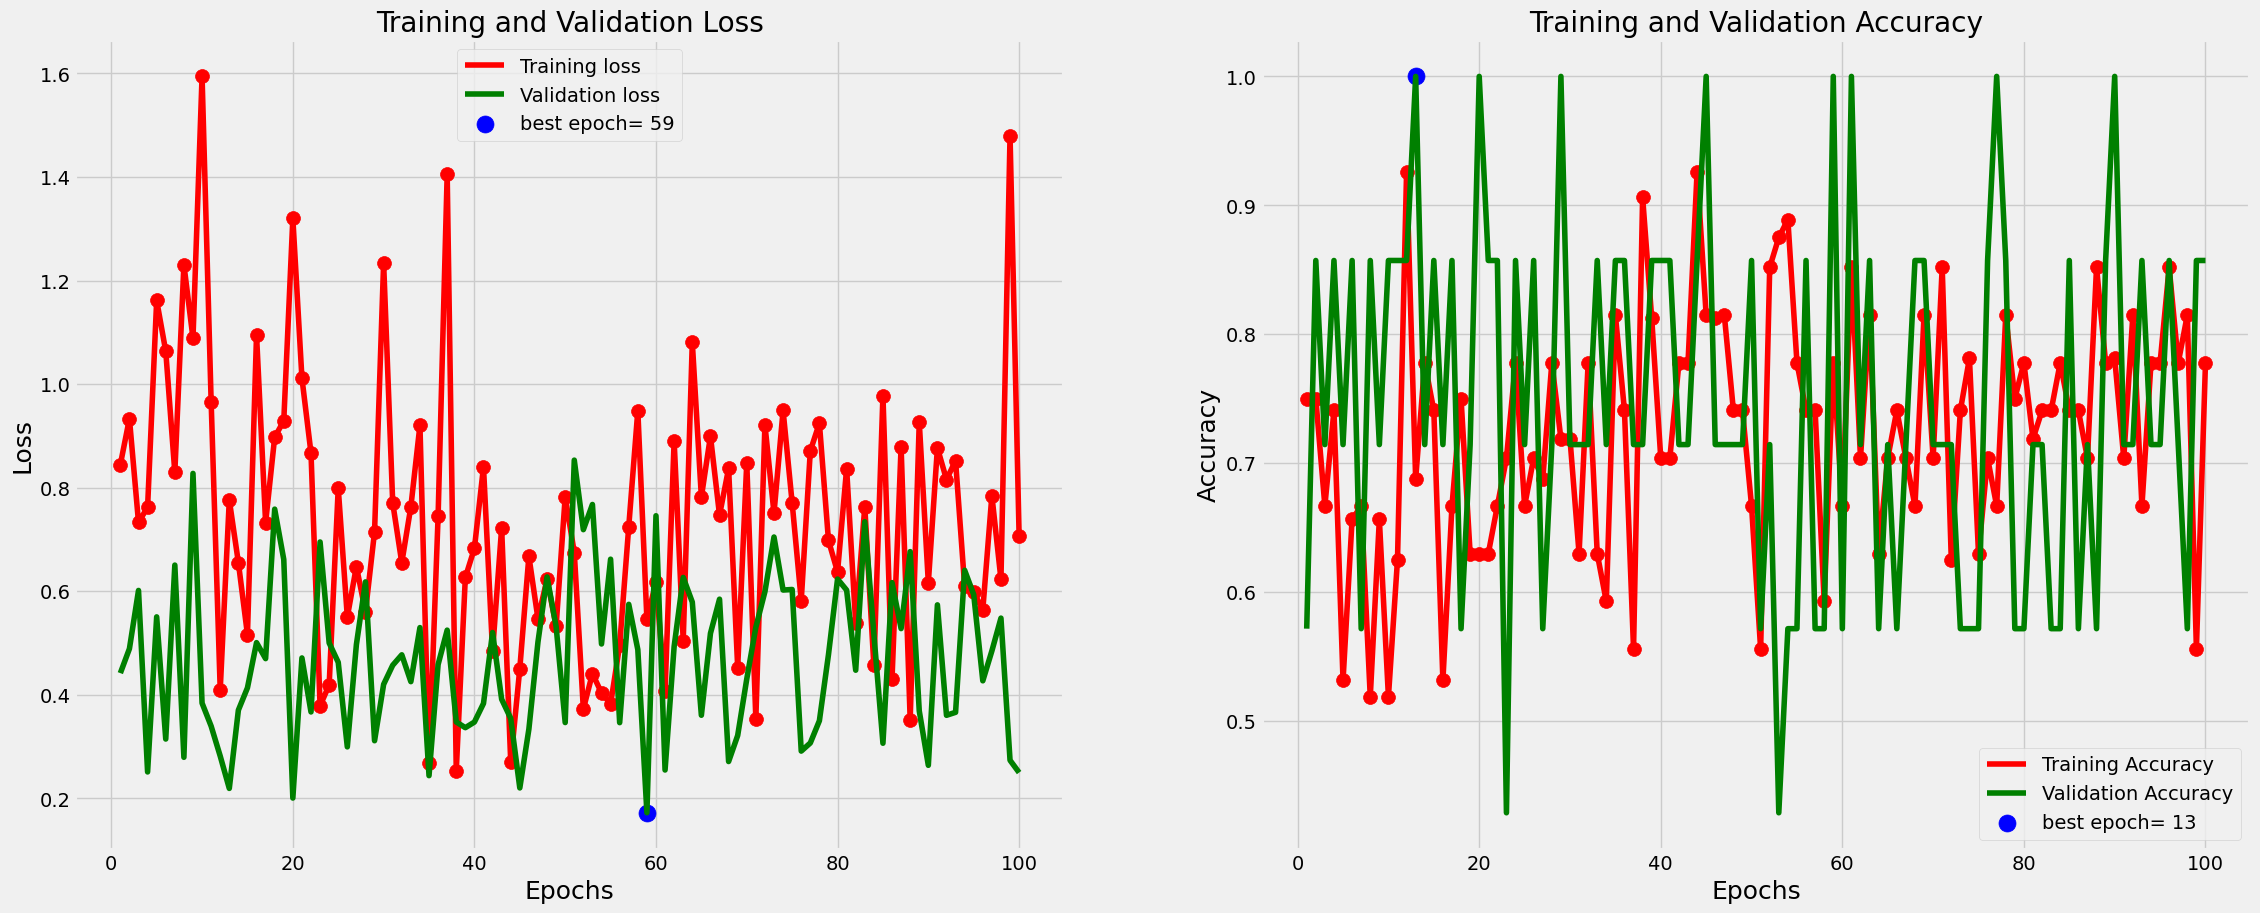

58

In [39]:
tr_plot(history,0)

In [40]:
#save the model
finetune_model.save_weights("Final_model.h5")

In [41]:
def load():
    model = load_model('Final_model.h5')
    return model
def test_predict(image_path,target_size=(300,300)):
    """Predictor_function to predict whether the 
    given indian currency is fake or not

    Args:
        image_path (str): input currency image path
        target_size (tuple): (300,300)
    """
    img=image.load_img(image_path,target_size=target_size) #The path of the testing image,the pic taken from the phone should come here
    img=np.asarray(img)
    plt.imshow(img)
    img=np.expand_dims(img,axis=0)
    finetune_model.load_weights("Final_model.h5")
    output=finetune_model.predict(img) #predicting the image using model created
    if(output[0][0]>output[0][1]): #comparison
        print("Fake")
    else:
        print("Real")

Real


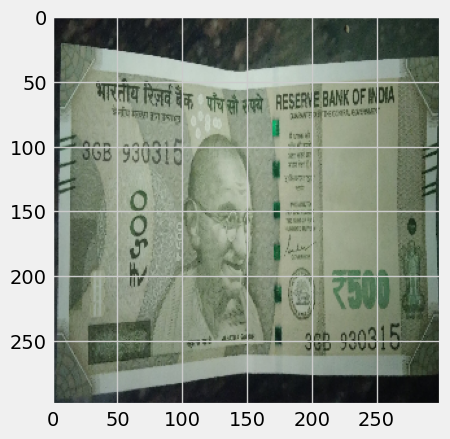

In [43]:
test_predict('Dataset\Testing\Real.jpg')

Fake


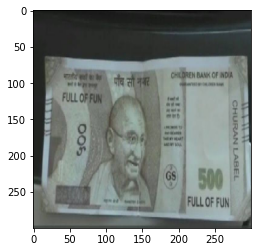

In [7]:
#testing the model
img=image.load_img("Dataset/Testing/Fake.jpeg",target_size=(300,300)) #The path of the testing image,the pic taken from the phone should come here
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
finetune_model.load_weights("Final_model.h5")

output=finetune_model.predict(img) #predicting the image using model created
if(output[0][0]>output[0][1]): #comparison
    print("Fake")
else:
    print("Real")